In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
clip1 = VideoFileClip("project_video.mp4")

In [3]:
img= clip1.get_frame(0)

In [4]:
filename = 'scripts/calibrate_camera.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))

filename = 'scripts/distortion_correct.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))

mtx, dist = read_camera_calibration('files/camera_calibration.p')
distortion_correcter = CorrectDistortion(mtx, dist)

In [5]:
corrected_image = distortion_correcter.correct(img)

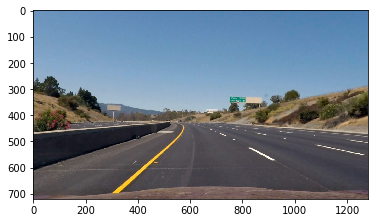

In [6]:
%matplotlib inline
plt.imshow(corrected_image)

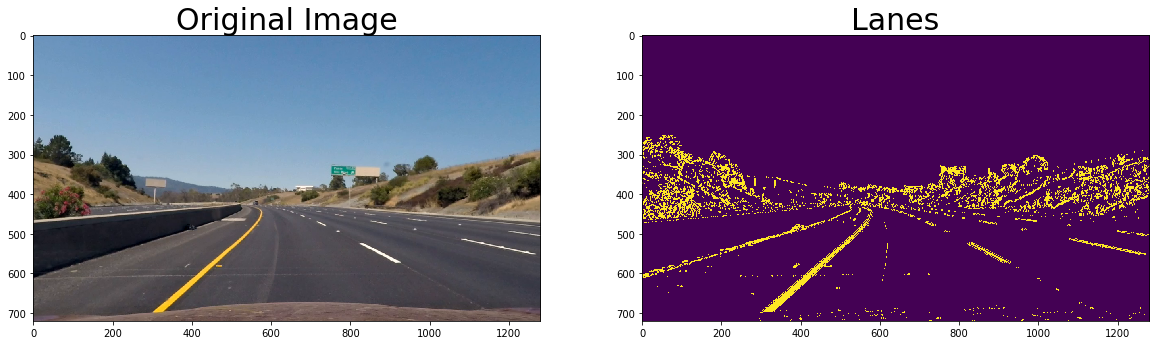

In [7]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(corrected_image)
ax1.set_title('Original Image', fontsize=30)
ax2.set_title('Lanes', fontsize=30)
filename = 'scripts/thresholding.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))
lane_extractor = ExtractLanes(        
        abs_x_sobel_kernel=5, abs_x_thresh=(20, 100),
        abs_y_sobel_kernel=3, abs_y_thresh=(20, 100),
        mag_thresh_sobel_kernel=3, mag_thresh=(30, 100),
        dir_thresh_sobel_kernel=15, dir_thresh=(0.7, 1.3),
        color_s_thresh = (170, 255)
)
binary = lane_extractor.extract_lanes(corrected_image)
ax2.imshow(binary)

In [8]:
src = np.float32([[257, 719], [584, 464], [714, 464], [1162, 719]])
dst = np.float32([[200, 700], [200, 0], [1000, 0], [1000, 700]])
M = cv2.getPerspectiveTransform(src, dst)
Minv= cv2.getPerspectiveTransform(dst, src)
img_size = (img.shape[1], img.shape[0])

In [9]:
binary_warped = cv2.warpPerspective(binary, M, img_size)

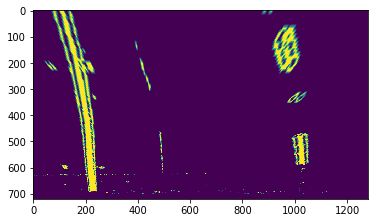

In [10]:
%matplotlib inline
plt.imshow(binary_warped)

In [21]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Assuming you have created a warped binary image called "binary_warped"
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

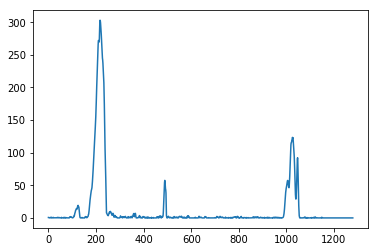

In [23]:
plt.plot(histogram)

(720, 0)

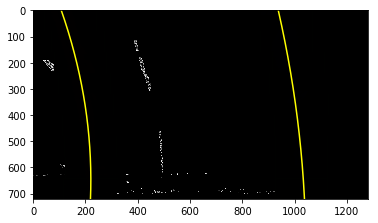

In [11]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
_ = cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)


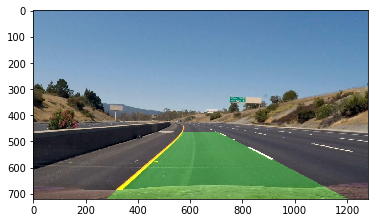

In [13]:
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)